In [38]:
from google.colab import files
from IPython.display import Image
uploaded = files.upload()

Saving model_plot2.PNG to model_plot2.PNG


# Embeding 

The idea is word and associated words are clustered as vectors in multi-dimensional space. 

For example, if search boring, we can see it lights up  in one cluster and asspocative words negatives such as unwatchable. 

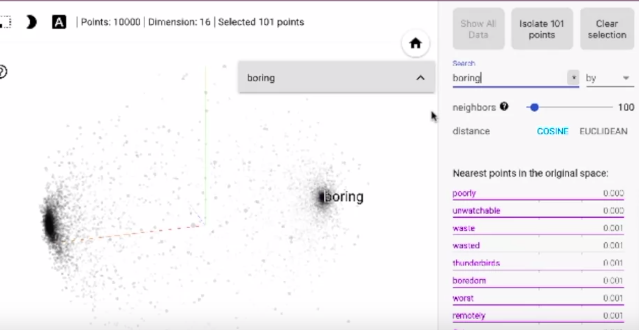

In [4]:
Image('output.PNG', width = 800)

## Dataset

A libary called TensorFlow Data Services (TFTS) that contains many data sets and lots of different categories. We use *imdb_reviews* dataset. This dataset is ideal, because it contains a large body of texts, 50000 movie reviews which are categorized as positive or negative. 

In [ ]:
#Install tensorflow datasets
pip install -q tensorflow-datasets

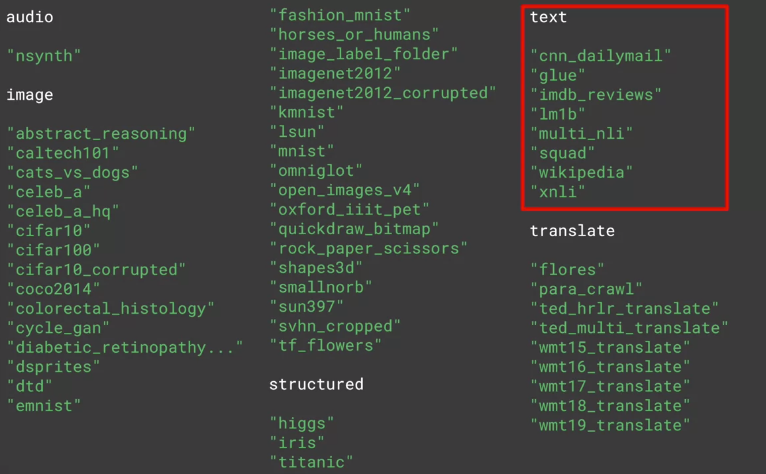

In [8]:
Image('dataset.PNG', width = 600)

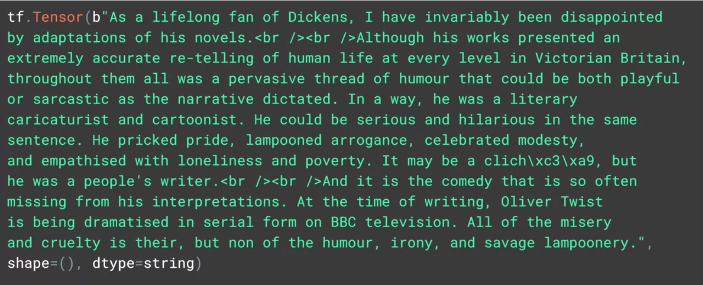

In [16]:
Image('tensor_dataset.PNG', width = 600) #show how data stored in Tensor

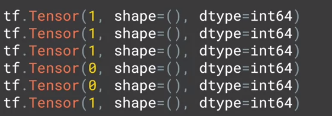

In [19]:
Image('tensor_dataset_label.PNG', width = 300) #show how label stored in Tensor

In [12]:
import tensorflow as tf
print(tf.__version__)

tf.enable_eager_execution() #1.x 
# if version is 2.x, don't need above code, because enable_eager_execution is default in TensorFlow 2.0

1.14.0


In [ ]:
#get the data
import tensorflow_datasets as tfds 
import numpy as np
imdb, info = tfds.load("imdb_reviews", with_info = True, as_supervised = True)
train_data, test_data = imdb['train'], imdb['test'] # have 25000 for training, 25000 for testing

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

for s, l in train_data:  #extract sentences and labels
  training_sentences.append(str(s.numpy())) # the value for s and i are tensor, use numpy() method to extract value
  training_labels.append(l.numpy())

for s, l in test_data: 
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())

training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)



In [ ]:
#tokenize sentences:

vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type = 'post'
oov_tok = "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 

tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences, maxlen = max_length, truncating = trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, truncating = trunc_type)


Embedding has similiar meanings that are close to each others. For example, a movie review might see dull and boring, or it might say fun and exciting. What if pick a vector in higher-dimenional space, **word are found together are given similar vectors**. Then over time, words begin to cluster together.  

For example, dull and boring shown a lot in negative review so that they ehave similar sentiments. 

As neural network training, it can learn these vectors with the labels to come up embedding, the vectors for each word with their associated sentiment 

The result of embedding will be **2D array** with **length of the sentence and embedding dimension** e.g. 16 as its size 


In [30]:
import tensorflow as tf
# Now defining our neural network

# this model is more accurate but more time to train
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(6, activation = tf.nn.relu),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                             
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 1920)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 11526     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [31]:
# this model is less accurate but less time to train

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation = tf.nn.relu),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                             
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 102       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 7         
Total params: 160,109
Trainable params: 160,109
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
num_epochs = 10
model.fit(padded, 
          training_labels_final, 
          epochs = num_epochs, 
          validation_data = (testing_padded, testing_labels_final))

e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) #shape: (vocab_size, embedding_dim), (10000, 16)
# 10000 words in corpus, and work in 16 dimensional array 

# To able to plot it, we need to reverse our word index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])


We use **subwords8k** for **imdb_reviews**, must use **tensorflow version 2.0+**, It has already have the token learned. So we can directly use them 


**Below model performance is not that good, because we ues subword not full words. Subwords often nonsensical only put them together has meaning**


In [41]:
# Once on tensorflow 2 + 

import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews/subwords8k", with_info = True, as_supervised = True)
train_data, test_data = imdb["train"], imdb["test"]


tokenizer = info.features["text"].encoder #access tokenizer

sample_string = "TensorFlow, from basics to mastery"

tokenized_string = tokenizer.encode(sample_string)
print("Tokenized string is {}".format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print("The original string: {}".format(original_string))

#TO see tokens themselves, take element and decode that

for ts in tokenized_string:
  print("{} ----> {}".format(ts, tokenizer.decode([ts]))) #This is case sensitive and punctuation maintained


model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(), #through embedding, is not easily flatten, try to flatten, will cause TensorFlow crash
    tf.keras.layers.Dense(6, activation = tf.nn.relu),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                             
])
num_epochs = 10
model.fit(padded, 
          training_labels_final, 
          epochs = num_epochs, 
          validation_data = (testing_padded, testing_labels_final))



Tokenized string is [6307, 2327, 4043, 2120, 2, 48, 4249, 4429, 7, 2652, 8050]
The original string: TensorFlow, from basics to mastery
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
2 ----> , 
48 ----> from 
4249 ----> basi
4429 ----> cs 
7 ----> to 
2652 ----> master
8050 ----> y



## Back to Scarcasm Dataset



In [ ]:
import json 
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000
embedding_dim = 16
max_length = 32
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"
trainging_size = 20000

with open("/tmp/sarcasm.json", 'r') as f:
  datastore = json.load(f)
  sentences = []
  labels = []
  for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])


In [ ]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

tokenizer.fit_on_texts(training_sentences)
wording_index = tokenizer.word_index 
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen = max_length, 
                                padding = padding_type, truncating= trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, 
                                padding = padding_type, truncating= trunc_type)

In [ ]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs = num_epochs,
                    validation_data = (testing_padded, testing_labels), verbose = 2)

In [ ]:
#simple plot 
import matplotlib.pyplot as plt 

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'acc')
plot_graphs(history, 'loss')

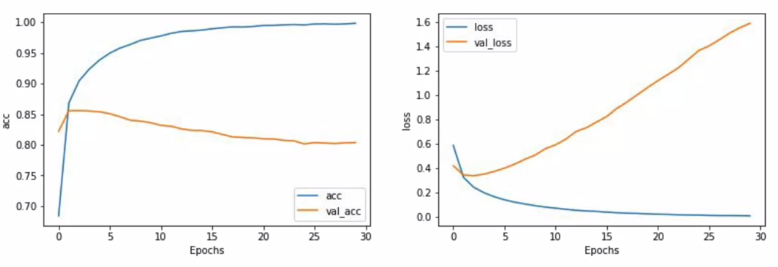

In [36]:
Image('model_plot.PNG', width = 800) 

### Confidence decrease

Think about loss as confidence of prediction. Loss on test set increase (Confidence decreases) when training epoch increase. It happen a lot with text data.If we **change hyperparameter** and rerun

In [ ]:
vocab_size = 1000    # was 10000
embedding_dim = 16
max_length = 16      # was 16   
trunc_type = "post"
padding_type = "post"
oov_tok = "<OOV>"
trainging_size = 20000

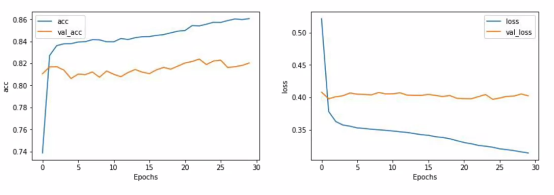

In [39]:
Image('model_plot2.PNG', width = 800) 

Make a hyperparameter separately is very easier for tweaking, and explore the impact of training